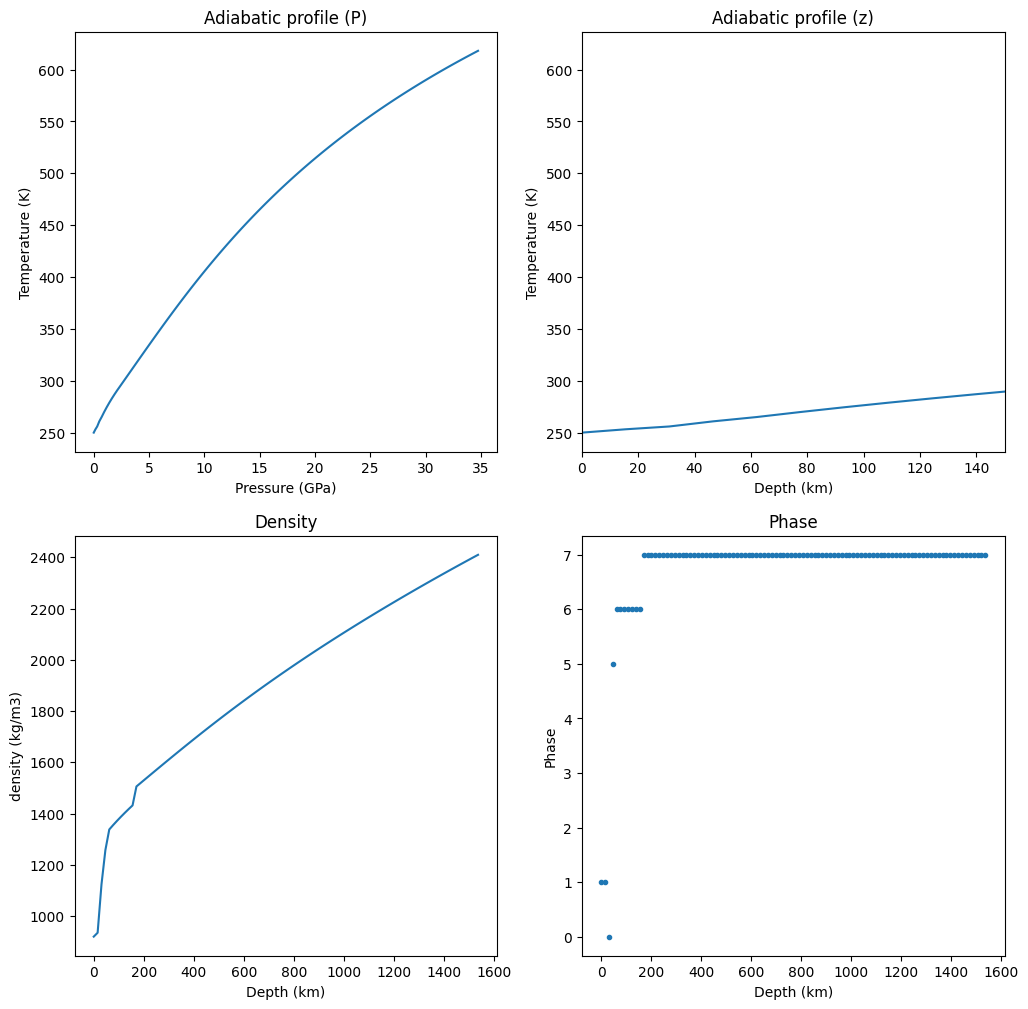

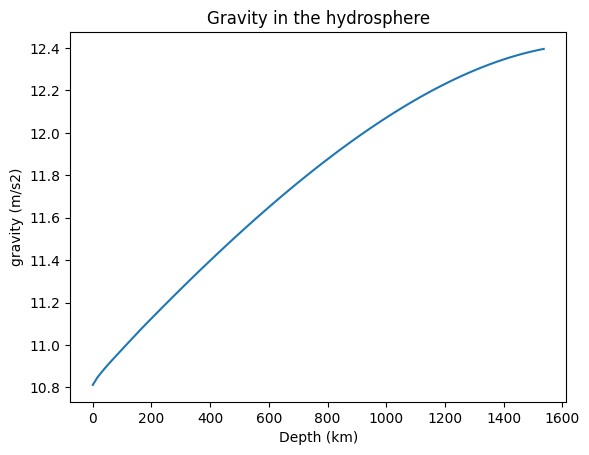

(array([      0.        ,   15525.45970111,   31050.91940222,
          46576.37910333,   62101.83880444,   77627.29850555,
          93152.75820667,  108678.21790778,  124203.67760889,
         139729.13731   ,  155254.59701111,  170780.05671222,
         186305.51641333,  201830.97611444,  217356.43581555,
         232881.89551666,  248407.35521778,  263932.81491889,
         279458.27462   ,  294983.73432111,  310509.19402222,
         326034.65372333,  341560.11342444,  357085.57312555,
         372611.03282666,  388136.49252777,  403661.95222889,
         419187.41193   ,  434712.87163111,  450238.33133222,
         465763.79103333,  481289.25073444,  496814.71043555,
         512340.17013666,  527865.62983777,  543391.08953888,
         558916.54924   ,  574442.00894111,  589967.46864222,
         605492.92834333,  621018.38804444,  636543.84774555,
         652069.30744666,  667594.76714777,  683120.22684888,
         698645.68654999,  714171.14625111,  729696.60595222,
        

In [36]:
import numpy as np
from seafreeze import seafreeze as sf
import matplotlib.pyplot as plt
from tabulate import tabulate

def gibbs_min(PT):
    phases = np.array(['water1', 'Ih', 'II', 'III', 'V', 'VI', 'VII_X_French']) 
    phase_nums = np.array([0, 1, 2, 3, 5, 6, 7]) 
    G = [sf.seafreeze(PT, j).G for j in phases]
    out = phase_nums[G.index(min(i for i in G if not np.isnan(i)))]
    return out   

def HydroSphere(Ps, Ts, Mw, Mc, Rhoc, resolution=100, G_iter=3, M_thresh=0.01, compute_conductivity=False):
        
    plot_flg = 1 # plot flag: 0=no plot; 1=plot
    
    Rc = (3 * Mc / (4 * np.pi * Rhoc)) ** (1. / 3.)   
    g_s = 6.67430e-11 * Mc / Rc**2  
    depth = (Mw / 800 / (4./3. * np.pi) + Rc**3)**(1./3.) - Rc 
    
    rho = np.empty(resolution)  # Density grid
    alpha = np.empty(resolution)  # thermal epansivity grid
    Cp = np.empty(resolution)  # Heat capacity grid
    dT_dz = np.empty(resolution)  # thermal gradient grid
    phase = np.empty(resolution)  # phase grid
    T = np.empty(resolution)  # Temperature grid
    P = np.empty(resolution)  # resolution grid
    grav = np.empty(resolution) # gravity grid
    PT = np.empty((1,), object)
    
    Mass_diff = 1
    
    while (Mass_diff > M_thresh):
        
        # initializing the grids
        z = np.linspace(0, depth, num=resolution)  # depth grid
        dz = np.diff(z)
        
        # For mass loop the factor being iterated is /depth/
        
        grav = g_s * np.ones(resolution)
    
        # Gravity conversion loop
        for k in range(G_iter): 
    
            # For gravity loop the factor being iterated is /grav/
            g = grav[::-1]  
            PT[0] = (Ps, Ts)
                
            if Ps > 2200:
                Tm = ((Ps * 1e-3 - 2.17) / 1.253 + 1)**(1/3) * 354.8 
                if Ts < Tm:
                    phase_s = 7
                else:
                    phase_s = 0
            else:
               phase_s = gibbs_min(PT)
            out = sf.seafreeze(PT,sf.phasenum2phase(phase_s)) # only calc rho, Cp, alpha 
    
            T[0] = Ts
            P[0] = Ps
            rho[0] = out.rho
            alpha[0] = out.alpha
            Cp[0] = out.Cp
            dT_dz[0] = out.alpha * g[0] * Ts / out.Cp
            phase[0] = phase_s
            
            for i in range(1, z.size):   
                T[i] = T[i - 1] + dT_dz[i - 1] * dz[i - 1]
                P[i] = P[i - 1] + rho[i - 1] * g[i - 1] * dz[i - 1] * 1e-6
                PT[0] = (P[i], T[i])
                
                if P[i] > 2200:
                    Tm = ((P[i] * 1e-3 - 2.17) / 1.253 + 1)**(1/3) * 354.8
                    if T[i] < Tm:
                        phase[i] = 7
                    else:
                        phase[i] = 0
                else:
                    phase[i] = gibbs_min(PT)
              
                out = sf.seafreeze(PT,sf.phasenum2phase(phase[i]))
                rho[i] = out.rho
                alpha[i] = out.alpha
                Cp[i] = out.Cp
                dT_dz[i] = out.alpha * g[i] * T[i] / out.Cp
                
            M_L = rho[1:] * 4/3 * np.pi * ((Rc + z[:-1] + (depth / resolution)) ** 3 - (Rc + z[:-1])**3)
            M_L = np.insert(M_L, 0, 0)
            Mass_Shells = np.cumsum(M_L[::-1])
            grav = 6.67430e-11 * (Mc + Mass_Shells) / (Rc + z)**2
    
        Mass_WL = np.sum(M_L)
        Mass_diff = Mw - Mass_WL
        depth_diff = (Mass_diff / (np.mean(rho) * 1.8) / (4/3 * np.pi) + Rc**3) ** (1/3) - Rc
    depth += depth_diff
    
    Mass_diff = np.abs(Mass_diff / Mw)
    
    if plot_flg == 1:        
        fig= plt.figure(figsize=(12,12))
        plt.subplots_adjust(wspace=0.2 , hspace=0.2)
        plt.subplot(221)
        plt.xlabel('Pressure (GPa)')
        plt.ylabel('Temperature (K)')
        plt.title('Adiabatic profile (P)')
        plt.plot(P*1e-3, T, '-')

        
        plt.subplot(222) 
        plt.xlabel('Depth (km)')
        plt.ylabel('Temperature (K)')
        plt.title('Adiabatic profile (z)')
        plt.plot(z*1e-3, T, '-')
        #ax = plt.gca()
        #ax.set_xlim([0, 150])
        
        plt.subplot(223)  
        plt.xlabel('Depth (km)')
        plt.ylabel('density (kg/m3)')
        plt.title('Density')
        plt.plot(z*1e-3, rho, '-')
        
        plt.subplot(224)  
        plt.xlabel('Depth (km)')
        plt.ylabel('Phase')
        plt.title('Phase')
        plt.plot(z*1e-3, phase, '.')
        
        plt.show()
        
        # plot gravity
        plt.xlabel('Depth (km)')
        plt.ylabel('gravity (m/s2)')
        plt.title('Gravity in the hydrosphere')
        plt.plot(z*1e-3, np.flip(grav,0), '-')
        
        plt.show()

    return z, rho, alpha, Cp, dT_dz, phase, T, P, grav 
    
# HydroSphere(0.1, 260, 3e+23, 5.6e24, 5500, resolution=100, G_iter=3, M_thresh=0.01, compute_conductivity=False)
HydroSphere(0.1, 250, 2*5.972e+24*0.1, 2*5.94e24, 5514, resolution=100, G_iter=3, M_thresh=0.01, compute_conductivity=False)

# def HydroSphere(Ps (surface P), Ts (surface T), Mw (mass of water), Mc (mass of rocky core), Rhoc (density of ""), resolution=100, G_iter=3, M_thresh=0.01, compute_conductivity=False):
# 5.94e24 is earth/ "rocky core" mass, 5514 is core density 
# 0.8, 1, 1.5 2 earth mass with 1, 5, 10 % H2O for a surface temperature of 300, 270 and 250K
